# Experiment x-1
All Samples, including labeled and non-labeled samples

## Dataset

In [2]:
import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
ROOT_DIR = os.getcwd()
sys.path.insert(0, ROOT_DIR)

In [4]:
def train_test_split(X, y, train_test_idx):
    X_train_df = X.loc[train_test_idx["train"]]
    X_test_df = X.loc[train_test_idx["test"]]

    y_train = y.loc[train_test_idx["train"]]
    y_test = y.loc[train_test_idx["test"]]

    return X_train_df, X_test_df, y_train, y_test

In [5]:
def setup_train_test_idx(
    X, last_train_time_step, last_time_step, aggregated_timestamp_column="time_step"
):
    """The aggregated_time_step_column needs to be a column with integer values, such as year, month or day"""

    split_timesteps = {}

    split_timesteps["train"] = list(range(last_train_time_step + 1))
    split_timesteps["test"] = list(range(last_train_time_step + 1, last_time_step + 1))

    train_test_idx = {}
    train_test_idx["train"] = X[
        X[aggregated_timestamp_column].isin(split_timesteps["train"])
    ].index
    train_test_idx["test"] = X[
        X[aggregated_timestamp_column].isin(split_timesteps["test"])
    ].index

    return train_test_idx

In [6]:
def combine_dataframes(df_classes, df_features, only_labeled=True):
    df_combined = pd.merge(
        df_features, df_classes, left_on="id", right_on="txId", how="left"
    )
    if only_labeled == True:
        df_combined = df_combined[df_combined["class"] != 2].reset_index(drop=True)
    df_combined.drop(columns=["txId"], inplace=True)
    return df_combined

In [7]:
def rename_classes(df_classes):
    df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)
    return df_classes

In [8]:
def rename_features(df_features):
    df_features.columns = (
        ["id", "time_step"]
        + [f"trans_feat_{i}" for i in range(93)]
        + [f"agg_feat_{i}" for i in range(72)]
    )
    return df_features

In [9]:
def import_elliptic_data_from_csvs():
    df_classes = pd.read_csv(
        os.path.join(ROOT_DIR, "datasets/elliptic/elliptic_txs_classes.csv")
    )
    df_edges = pd.read_csv(
        os.path.join(ROOT_DIR, "datasets/elliptic/elliptic_txs_edgelist.csv")
    )
    df_features = pd.read_csv(
        os.path.join(ROOT_DIR, "datasets/elliptic/elliptic_txs_features.csv"),
        header=None,
    )
    return df_classes, df_edges, df_features

In [10]:
def load_elliptic_data(only_labeled=True, drop_node_id=True):
    df_classes, df_edges, df_features = import_elliptic_data_from_csvs()
    df_features = rename_features(df_features)
    df_classes = rename_classes(df_classes)
    df_combined = combine_dataframes(df_classes, df_features, only_labeled)

    if drop_node_id == True:
        X = df_combined.drop(columns=["id", "class"])
    else:
        X = df_combined.drop(columns="class")

    y = df_combined["class"]

    return X, y

In [11]:
def run_elliptic_preprocessing_pipeline(
    last_train_time_step, last_time_step, only_labeled=True, drop_node_id=True
):
    print(f'run_elliptic_preprocessing_pipeline {only_labeled}')
    X, y = load_elliptic_data(only_labeled, drop_node_id)
    train_test_idx = setup_train_test_idx(X, last_train_time_step, last_time_step)
    X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, train_test_idx)

    return X_train_df, X_test_df, y_train, y_test

## EFC

In [12]:
from efc import EnergyBasedFlowClassifier

In [13]:
# Elliptic data set timestep
last_time_step = 49
last_train_time_step = 34
only_labeled = False

In [14]:
X_train_df, X_test_df, y_train, y_test = run_elliptic_preprocessing_pipeline(
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
    only_labeled=only_labeled,
)

run_elliptic_preprocessing_pipeline False


/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_11901/3533226547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)


In [15]:
results_efc = 'results/efc/experiment-x-1'

In [16]:
# make experiments results dir if not exists
if not os.path.exists(results_efc):
    os.makedirs(results_efc)

In [17]:
sizes = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [18]:
df_sizes = pd.DataFrame(data=sizes, index=[0])

In [19]:
df_sizes

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,203769,203769,136265,67504,136265,67504,3462,26432,1083,15587


In [20]:
clf = EnergyBasedFlowClassifier(n_bins=10, cutoff_quantile=0.95)

In [21]:
clf.fit(X_train_df, y_train, base_class=0)

EnergyBasedFlowClassifier(n_bins=10)

In [22]:
y_pred, y_energies = clf.predict(X_test_df, return_energies=True)

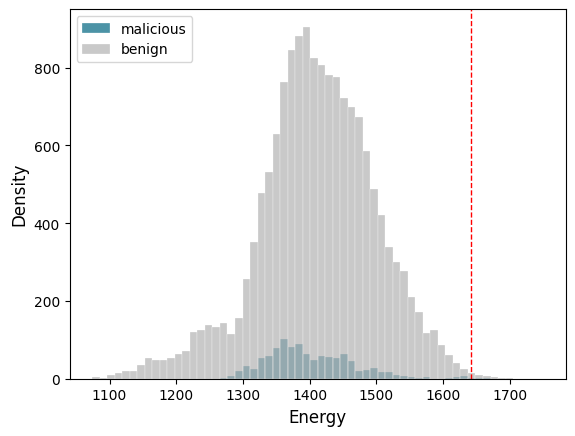

<Figure size 640x480 with 0 Axes>

In [23]:
# ploting energies
benign = np.where(y_test == 0)[0]
malicious = np.where(y_test == 1)[0]

benign_energies = y_energies[benign]
malicious_energies = y_energies[malicious]
cutoff = clf.estimators_[0].cutoff_

bins = np.histogram(y_energies, bins=60)[1]

plt.hist(
    malicious_energies,
    bins,
    facecolor="#006680",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="malicious",
)
plt.hist(
    benign_energies,
    bins,
    facecolor="#b3b3b3",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="benign",
)
plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
plt.legend()

plt.xlabel("Energy", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.show()
plt.savefig(f'{results_efc}/1_all_samples.png')

In [24]:
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix
)

In [25]:
def calculate_model_score(y_true, y_pred):
    metric_dict = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="weighted"),
        "f1_micro": f1_score(y_true, y_pred, average="micro"),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted"),
    }
    return metric_dict

In [26]:
model_score = calculate_model_score(y_true=y_test.values, y_pred=y_pred)

In [27]:
df_efc_metrics = pd.DataFrame(data=model_score, index=[0])

In [28]:
df_efc_metrics

,accuracy,f1,f1_micro,f1_macro,precision,recall
0,0.533983,0.550505,0.533983,0.488404,0.805546,0.533983


In [29]:
labels_cm = ["True Negative", "False positive", "False Negative", "True Positive"]

In [30]:
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

In [31]:
cm = np.reshape(cm, -1).tolist()

In [32]:
cm

[664, 359, 4, 14783]

In [33]:
confusion_matrix = {'Technique': 'All samples'} | {label: val for val, label in zip(cm, labels_cm)}

In [34]:
confusion_matrix

{'Technique': 'All samples',
 'True Negative': 664,
 'False positive': 359,
 'False Negative': 4,
 'True Positive': 14783}

In [102]:
only_labeled = True

X_train_df, X_test_df, y_train, y_test = run_elliptic_preprocessing_pipeline(
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
    only_labeled=only_labeled,
)

run_elliptic_preprocessing_pipeline True
load_elliptic_data True


/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_47144/3533226547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)


In [119]:
idx_abnormal = np.where(y_train == 1)[0]  # find abnormal samples indexes in the training set

In [120]:
X_train_df.drop(idx_abnormal, axis=0, inplace=True)  # remove abnormal samples from training (EFC trains with only benign instances)

In [105]:
y_train.drop(idx_abnormal, axis=0, inplace=True)  # remove the corresponding abonrmal training targets

In [106]:
sizes = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [107]:
df_sizes_1 = pd.DataFrame(data=sizes, index=[0])

In [108]:
df_sizes_1

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,43102,43102,26432,16670,26432,16670,0,26432,1083,15587


In [109]:
clf = EnergyBasedFlowClassifier(n_bins=10, cutoff_quantile=0.95)

In [110]:
clf.fit(X_train_df, y_train, base_class=0)

EnergyBasedFlowClassifier(n_bins=10)

In [111]:
y_pred, y_energies = clf.predict(X_test_df, return_energies=True)

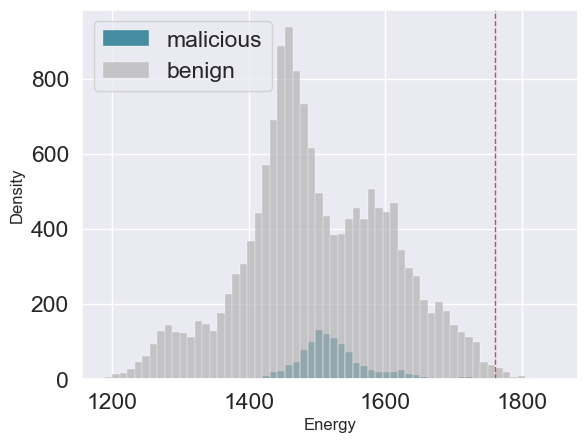

In [112]:
# ploting energies
benign = np.where(y_test == 0)[0]
malicious = np.where(y_test == 1)[0]

benign_energies = y_energies[benign]
malicious_energies = y_energies[malicious]
cutoff = clf.estimators_[0].cutoff_

bins = np.histogram(y_energies, bins=60)[1]

plt.hist(
    malicious_energies,
    bins,
    facecolor="#006680",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="malicious",
)
plt.hist(
    benign_energies,
    bins,
    facecolor="#b3b3b3",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="benign",
)
plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
plt.legend()

plt.xlabel("Energy", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.show()

In [113]:
model_score_2 = calculate_model_score(y_true=y_test.values, y_pred=y_pred)

/Users/kevinaraujo/.pyenv/versions/masters/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [114]:
model_score_2

{'accuracy': 0.9350329934013197,
 'f1': np.float64(0.9036400947482017),
 'f1_micro': np.float64(0.9350329934013197),
 'f1_macro': np.float64(0.4832129460272189),
 'precision': np.float64(0.8742866987490324),
 'recall': np.float64(0.9350329934013197)}

In [115]:
df_efc_metrics_1 = pd.DataFrame(data=model_score_2, index=[0])

In [116]:
df_efc_metrics_1

,accuracy,f1,f1_micro,f1_macro,precision,recall
0,0.935033,0.90364,0.935033,0.483213,0.874287,0.935033


In [62]:
only_labeled = True

X_train_df, X_test_df, y_train, y_test = run_elliptic_preprocessing_pipeline(
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
    only_labeled=only_labeled,
)

run_elliptic_preprocessing_pipeline True
load_elliptic_data True


/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_47144/3533226547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)


In [63]:
results_efc = 'results/efc'

In [64]:
sizes = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [65]:
df_sizes_1 = pd.DataFrame(data=sizes, index=[0])

In [66]:
df_sizes_1

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,46564,46564,29894,16670,29894,16670,3462,26432,1083,15587


In [67]:
clf = EnergyBasedFlowClassifier(n_bins=10, cutoff_quantile=0.95)

In [68]:
clf.fit(X_train_df, y_train, base_class=0)

EnergyBasedFlowClassifier(n_bins=10)

In [69]:
y_pred, y_energies = clf.predict(X_test_df, return_energies=True)

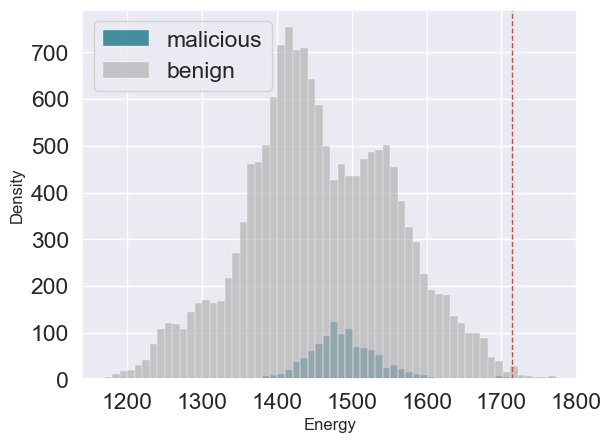

In [70]:
# ploting energies
benign = np.where(y_test == 0)[0]
malicious = np.where(y_test == 1)[0]

benign_energies = y_energies[benign]
malicious_energies = y_energies[malicious]
cutoff = clf.estimators_[0].cutoff_

bins = np.histogram(y_energies, bins=60)[1]

plt.hist(
    malicious_energies,
    bins,
    facecolor="#006680",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="malicious",
)
plt.hist(
    benign_energies,
    bins,
    facecolor="#b3b3b3",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="benign",
)
plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
plt.legend()

plt.xlabel("Energy", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.savefig(f'{results_efc}/experiment_2/1_labeled_samples.png')

In [71]:
model_score_3 = calculate_model_score(y_true=y_test.values, y_pred=y_pred)

In [72]:
df_efc_metrics_1 = pd.DataFrame(data=model_score_3, index=[0])

In [73]:
df_efc_metrics_1

,accuracy,f1,f1_micro,f1_macro,precision,recall
0,0.932034,0.902364,0.932034,0.484167,0.876608,0.932034


In [75]:
f1_macro_weighted = f1_score(y_true=y_test.values, y_pred=y_pred, average="weighted")

In [76]:
f1_macro_weighted

np.float64(0.9023642297215495)

In [77]:
f1_micro = f1_score(y_true=y_test.values, y_pred=y_pred, average="micro")

In [78]:
f1_micro

np.float64(0.9320335932813437)

In [79]:
f1_macro = f1_score(y_true=y_test.values, y_pred=y_pred, average="macro")

In [80]:
f1_macro

np.float64(0.4841674862120687)

In [81]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [82]:
labels_cm = ["True Negative", "False positive", "False Negative", "True Positive"]

In [83]:
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

In [84]:
cm = np.reshape(cm, -1).tolist()

In [85]:
cm

[2, 1081, 52, 15535]

In [86]:
confusion_matrix_1 = {'Technique': 'All labeled samples'} | {label: val for val, label in zip(cm, labels_cm)}

In [87]:
confusion_matrix_1

{'Technique': 'All labeled samples',
 'True Negative': 2,
 'False positive': 1081,
 'False Negative': 52,
 'True Positive': 15535}

In [139]:
f1_pos_label = f1_score(y_true=y_test.values, y_pred=y_pred, pos_label=0)

In [140]:
f1_pos_label

np.float64(0.9664258920544379)

In [90]:
precision = precision_score(y_test.values, y_pred)
recall = recall_score(y_test.values, y_pred)
f1score = f1_score(y_pred, y_test.values)

In [91]:
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")

Precision = 0.037037037037037035
Recall = 0.0018467220683287165
F1 Score = 0.003518029903254178


In [92]:
malicious_test = np.where(y_test == 1)[0]

In [95]:
len(malicious_test)

1083

In [93]:
malicious_pred = np.where(y_pred == 1)[0]

In [96]:
len(malicious_pred)

54

In [97]:
benign_test = np.where(y_test == 0)[0]

In [99]:
len(benign_test)

15587

In [100]:
benign_pred = np.where(y_pred == 0)[0]

In [101]:
len(benign_pred)

16616

In [121]:
def pfbeta(labels, predictions, beta):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

In [129]:
y_test.values

array([0, 0, 0, ..., 1, 0, 1])

In [132]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [136]:
clf.estimators_

[BaseEFC(max_bin=np.int64(10))]

np.float64(1760.4638370517835)

In [127]:
pfbeta_val = pfbeta(labels=y_test.values, predictions=y_pred, beta=0.5)

/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_47144/2062793374.py:15: RuntimeWarning: invalid value encountered in scalar divide
  c_precision = ctp / (ctp + cfp)


In [128]:
pfbeta_val

0